In [19]:
import pandas as pd 
import sys
from pathlib import Path
import numpy as np

In [20]:
data_layers = ['gene_id', 'ip_vars', 'etp_vars', 'pathways', 'clinical_vars',
       'variants', 'per_gene_alterations', 'subtype']



def _align_xy(dfs, labels):
	"""Intersect by sample ID index across all dfs and labels; align and concatenate features horizontally."""
	common_idx = labels.index.astype(str)
	for df in dfs:
		common_idx = common_idx.intersection(df.index.astype(str))
	if len(common_idx) == 0:
		raise ValueError("No common samples between selected datasets and labels after alignment.")

	# Align and concat features
	aligned_dfs = [df.loc[common_idx].sort_index() for df in dfs]
	X = pd.concat(aligned_dfs, axis=1)
	y = labels.loc[common_idx].sort_index()

	# Basic cleaning: drop all-NaN columns, fill remaining NaNs with 0
	X = X.dropna(axis=1, how="all").fillna(0)
	# Ensure numeric dtype (convert booleans to ints)
	for col in X.columns:
		if pd.api.types.is_bool_dtype(X[col]):
			X[col] = X[col].astype(np.int8)
		elif not pd.api.types.is_numeric_dtype(X[col]):
			# Attempt coercion; non-convertible become NaN then fill with 0
			X[col] = pd.to_numeric(X[col], errors="coerce").fillna(0)
	return X, y

def _read_labels(labels_path: Path, label_column: str = "Reviewed.subtype") -> pd.Series:
	df = pd.read_pickle(labels_path)
	if label_column not in df.columns:
		raise KeyError(f"Label column '{label_column}' not found in {labels_path}. Available: {list(df.columns)}")
	# Preserve original index (sample IDs)
	ser = df[label_column]
	ser = ser.astype(str)
	return ser


def _filter_labels(labels: pd.Series, exclude_terms:  None , include_terms: None) -> pd.Series:
	if not exclude_terms and not include_terms:
		return labels
	if include_terms:
		mask = pd.Series(False, index=labels.index)
		for term in include_terms:
			mask |= labels.str.contains(str(term), na=False)
		return labels[mask]
	mask = pd.Series(True, index=labels.index)
	for term in exclude_terms:
		mask &= ~labels.str.contains(str(term), na=False)
	return labels[mask]



files = {
		"Copy Number Variation": "cnvlr_final.csv",
		"DNA Variants": "DNA_variants_binary_final.csv",
		"Clinical Data": "processed_clinical_data_final_with_cns.csv",
		"Gene Expression": "Tall_gexp_cleaned.csv",}
	
datasets= {}
data_dir = Path('.')
labels = _read_labels(data_dir / "labels_final.pkl", label_column="Reviewed.subtype")
labels.index = labels.index.astype(str)

annotations = pd.read_csv('annotations.csv', index_col=0)
labels = labels.loc[labels.index.astype(str).intersection(annotations.index.astype(str))]
labels.shape

(1309,)

In [21]:
polonen_rna = 'RNA/pölönen.tsv'
bfm_tall = 'RNA/bfm.tsv'
hackenhaar_rna = 'RNA/hackenhaar.tsv'

bfm_tall = pd.read_csv(bfm_tall, index_col=0, sep='\t')
polonen_rna = pd.read_csv(polonen_rna, index_col=0, sep='\t')
hackenhaar_rna = pd.read_csv(hackenhaar_rna, index_col=0, sep='\t')
polonen_rna = polonen_rna.loc[labels.index]

In [22]:
labels_italy = pd.read_csv('res/predictions_probs_BFM_italy.csv', index_col=0).idxmax(axis=1)
labels_italy = pd.DataFrame(labels_italy, columns=['pred_subtype'])
labels_italy['pred_subtype'] = [i.split('_')[1] for i in labels_italy['pred_subtype']]
labels_italy = labels_italy.loc[labels_italy.index.astype(str).intersection(bfm_tall.index.astype(str))]
labels_italy
bfm_tall = bfm_tall.loc[labels_italy.index]

In [23]:
labels_hackenhaar = pd.read_csv('res/predictions_probs_Hackenhaar.csv', index_col=0).idxmax(axis=1)
labels_hackenhaar = pd.DataFrame(labels_hackenhaar, columns=['pred_subtype'])
labels_hackenhaar['pred_subtype'] = [i.split('_')[1] for i in labels_hackenhaar['pred_subtype']]
labels_hackenhaar = labels_hackenhaar.loc[labels_hackenhaar.index.astype(str).intersection(hackenhaar_rna.index.astype(str))]

labels_hackenhaar = labels_hackenhaar.drop(index=['CD3', 'CD34', 'Lymphnode'])
hackenhaar_rna = hackenhaar_rna.loc[labels_hackenhaar.index]

In [24]:
from umap import UMAP
import matplotlib.pyplot as plt
# Combine datasets for UMAP visualization

umap_model = UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
embedding = umap_model.fit_transform(polonen_rna) 
embedding2 = umap_model.transform(bfm_tall)
embedding3 = umap_model.transform(hackenhaar_rna)


c:\Users\stoib\miniconda3\envs\tall-analysis\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [25]:
fusion_to_subtype = {
    "ETV6::NCOA2": "ETP-like",
    "ETV6::ABL1": "TLX3",
    "KMT2A::CBL": "ETP-like",
    "KMT2A::ELL": "ETP-like",
    "KMT2A::AFDN": "ETP-like or KMT2A",
    "KMT2A::MLLT1": "KMT2A",
    "PICALM::MLLT10": "ETP-like or MLLT10",
    "DDX3X::MLLT10": "ETP-like or MLLT10",
    "SET::NUP214": "ETP-like or NUP214",
    "NUP214::ABL1": "TLX1 or TLX3",
    "STIL::TAL1": "TAL1 DP-like or TAL1 αβ-like",
    "STMN1::SPI1": "SPI1"
}
predictions_italy = pd.read_csv('res/predictions_probs_BFM_italy.csv', index_col=0).idxmax(axis=1)
predictions_italy = pd.DataFrame(predictions_italy, columns=['predicted_subtype'])
predictions_italy['predicted_subtype'] = [i. split('_')[1] for i in predictions_italy['predicted_subtype']]
#figE = pd.read_csv('../output/figures/figE.csv', index_col=0)

In [26]:
predictions_italy.head()

,predicted_subtype
Pt_1,NKX2-5
Pt_2,NKX2-1
Pt_3,ETP-like
Pt_4,TAL1 αβ-like
Pt_5,TAL1 DP-like


In [27]:
labels_italy = pd.read_csv('RNA/Italylabels.csv', index_col=0, sep=';').replace({'NEG': np.nan}).dropna()
labels_italy['FUSION'] = [i.replace('--', '::') for i in labels_italy['FUSION']]
labels_italy = labels_italy[labels_italy['FUSION'].isin(fusion_to_subtype.keys())]
labels_italy['SUBTYPE_PRED'] = labels_italy['FUSION'].map(fusion_to_subtype)
labels_italy = predictions_italy.join(labels_italy, how='inner')
print(len(labels_italy))
labels_italy

33


,predicted_subtype,CLASS,FUSION,SUBTYPE_PRED
Pt_11,MLLT10,MLLT10r,PICALM::MLLT10,ETP-like or MLLT10
Pt_12,TAL1 DP-like,STIL::TAL1,STIL::TAL1,TAL1 DP-like or TAL1 αβ-like
Pt_13,SPI1,others,STMN1::SPI1,SPI1
Pt_16,ETP-like,KMT2Ar,KMT2A::ELL,ETP-like
Pt_21,ETP-like,others,ETV6::NCOA2,ETP-like
Pt_22,TAL1 αβ-like,STIL::TAL1,STIL::TAL1,TAL1 DP-like or TAL1 αβ-like
Pt_26,MLLT10,KMT2Ar,KMT2A::AFDN,ETP-like or KMT2A
Pt_28,KMT2A,KMT2Ar,KMT2A::MLLT1,KMT2A
Pt_34,ETP-like,others,ETV6::NCOA2,ETP-like
Pt_37,TAL1 DP-like,STIL::TAL1,STIL::TAL1,TAL1 DP-like or TAL1 αβ-like


In [28]:
# Create the row labels by combining FUSION and SUBTYPE_PRED
labels_italy['Fusion --> Subtype'] = labels_italy['FUSION'] + '-->' + labels_italy['SUBTYPE_PRED']

# Create pivot table: count occurrences of each (fusion-->expected, predicted) pair
pivot_table = pd.crosstab(
    labels_italy['Fusion --> Subtype'], 
    labels_italy['predicted_subtype']
)

# Reorder columns to match desired order (optional)
desired_cols = ['ETP-like', 'KMT2A', 'MLLT10', 'TLX3', 'TLX1', 'TAL1 DP-like', 'TAL1 αβ-like', 'SPI1','TME-enriched', '']  # Added empty string for no prediction
# Filter to only include columns that exist
existing_cols = [c for c in desired_cols if c in pivot_table.columns]
pivot_table = pivot_table.reindex(columns=existing_cols, fill_value=0)

# Reorder rows based on fusion_to_subtype dict order
row_order = [f"{fusion}-->{subtype}" for fusion, subtype in fusion_to_subtype.items()]
existing_rows = [r for r in row_order if r in pivot_table.index]
pivot_table = pivot_table.reindex(existing_rows, fill_value=0)

pivot_table['AssignedSubtypes'] = [row.split('-->')[1].split(' or ') for row in pivot_table.index]
correct_counts = []
for idx, row in pivot_table.iterrows():
    assigned_subtypes = row['AssignedSubtypes']
    correct_count = sum(row[subtype] for subtype in assigned_subtypes if subtype in pivot_table.columns)
    correct_counts.append(correct_count)

pivot_table

predicted_subtype,ETP-like,KMT2A,MLLT10,TLX3,TAL1 DP-like,TAL1 αβ-like,SPI1,TME-enriched,AssignedSubtypes
Fusion --> Subtype,,,,,,,,,
ETV6::NCOA2-->ETP-like,2,0,0,0,0,0,0,0,[ETP-like]
ETV6::ABL1-->TLX3,0,0,0,1,0,0,0,0,[TLX3]
KMT2A::CBL-->ETP-like,1,0,0,0,0,0,0,0,[ETP-like]
KMT2A::ELL-->ETP-like,1,0,0,0,0,0,0,1,[ETP-like]
KMT2A::AFDN-->ETP-like or KMT2A,1,0,1,0,0,0,0,0,"[ETP-like, KMT2A]"
KMT2A::MLLT1-->KMT2A,0,2,0,0,0,0,0,0,[KMT2A]
PICALM::MLLT10-->ETP-like or MLLT10,3,1,3,0,0,0,0,0,"[ETP-like, MLLT10]"
DDX3X::MLLT10-->ETP-like or MLLT10,0,0,1,0,0,0,0,0,"[ETP-like, MLLT10]"
SET::NUP214-->ETP-like or NUP214,0,0,2,0,0,0,0,0,"[ETP-like, NUP214]"


In [29]:
acc = sum(correct_counts) / len(labels_italy)
print('Accuracy:', acc)

Accuracy: 0.8181818181818182


In [30]:
wrong_predictions = []
for idx, row in pivot_table.iterrows():
    assigned_subtypes = row['AssignedSubtypes']
    for col in pivot_table.columns[:-1]:
        if col not in assigned_subtypes and row[col] > 0:
            wrong_predictions.append((idx, col))
wrong_predictions = [(wp[0].replace('-->','\n \t $\\rightarrow$'), wp[1]) for wp in wrong_predictions]
wrong_predictions

[('KMT2A::ELL\n \t $\\rightarrow$ETP-like', 'TME-enriched'),
 ('KMT2A::AFDN\n \t $\\rightarrow$ETP-like or KMT2A', 'MLLT10'),
 ('PICALM::MLLT10\n \t $\\rightarrow$ETP-like or MLLT10', 'KMT2A'),
 ('SET::NUP214\n \t $\\rightarrow$ETP-like or NUP214', 'MLLT10'),
 ('NUP214::ABL1\n \t $\\rightarrow$TLX1 or TLX3', 'TAL1 αβ-like')]

In [31]:
pivot_table.drop(columns=['AssignedSubtypes'], inplace=True)

In [32]:
if 'Predicted Subtype' not in predictions_italy.columns:
        predictions_italy.rename(columns={'predicted_subtype': 'Predicted Subtype'}, inplace=True)

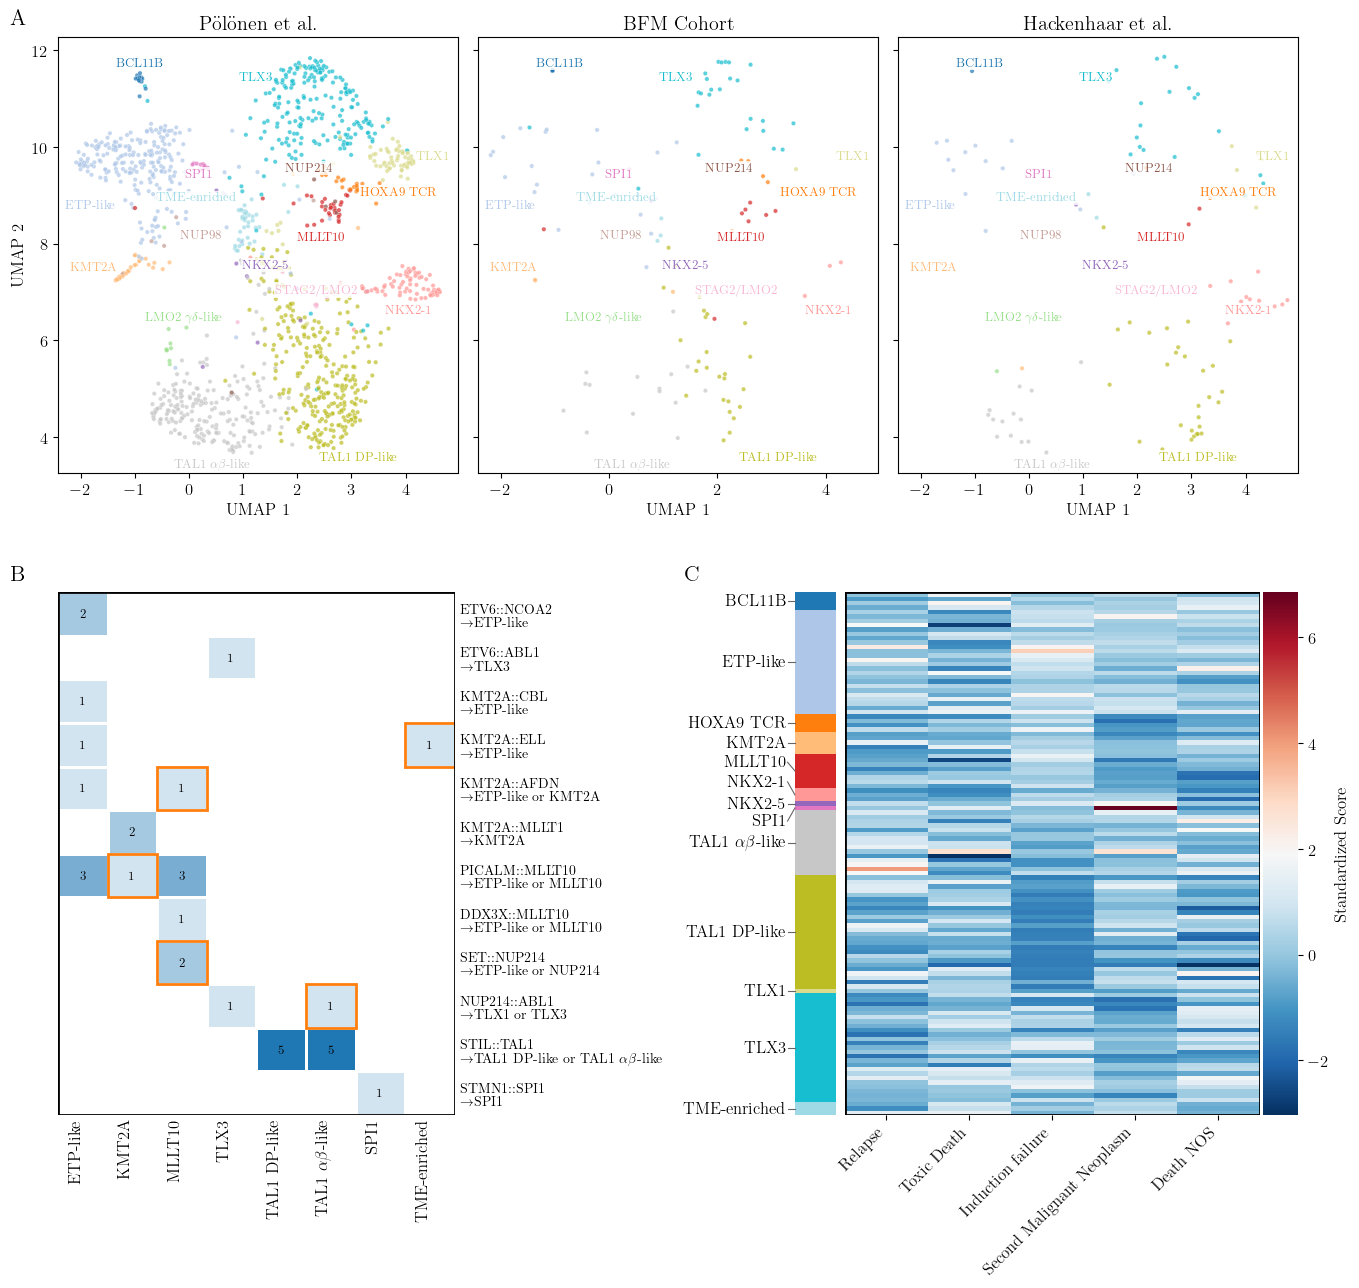

In [39]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.spatial import ConvexHull

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
    "font.size": 12,
    "axes.labelsize": 12,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12
})

# === Define consistent color palette for subtypes ===
labels_plot = labels.str.replace('γ', r'$\gamma$', regex=False)\
                     .str.replace('δ', r'$\delta$', regex=False)\
                     .str.replace('α', r'$\alpha$', regex=False)\
                     .str.replace('β', r'$\beta$', regex=False)\
                     .str.replace('&', r'\&', regex=False)

labels_plot_italy = predictions_italy['Predicted Subtype'].str.replace('γ', r'$\gamma$', regex=False).str.replace('δ', r'$\delta$', regex=False).str.replace('α', r'$\alpha$', regex=False)\
                        .str.replace('β', r'$\beta$', regex=False)\
                        .str.replace('&', r'\&', regex=False)


labels_plot_hackenhaar = labels_hackenhaar['pred_subtype'].str.replace('γ', r'$\gamma$', regex=False).str.replace('δ', r'$\delta$', regex=False).str.replace('α', r'$\alpha$', regex=False)\
                        .str.replace('β', r'$\beta$', regex=False)\
                        .str.replace('&', r'\&', regex=False)


all_subtypes = labels_plot.unique()
colors = plt.cm.tab20(np.linspace(0, 1, len(all_subtypes)))
subtype_colors = {st: colors[i] for i, st in enumerate(sorted(all_subtypes))}

"""# === Compute convex hulls for each subtype ===
def compute_hulls(embedding, labels_series, subtype_colors, percentile=75):

    hulls = {}
    for subtype in labels_series.unique():
        mask = labels_series.values == subtype
        points = embedding[mask]
        if len(points) >= 3:  # Need at least 3 points for a hull
            try:
                # Compute centroid
                centroid = points.mean(axis=0)
                # Compute distances from centroid
                distances = np.linalg.norm(points - centroid, axis=1)
                # Keep only points within the specified percentile
                threshold = np.percentile(distances, percentile)
                inlier_mask = distances <= threshold
                inlier_points = points[inlier_mask]
                
                if len(inlier_points) >= 3:
                    hull = ConvexHull(inlier_points)
                    hulls[subtype] = {
                        'points': inlier_points,
                        'hull': hull,
                        'color': subtype_colors.get(subtype, 'gray')
                    }
            except:
                pass  # Skip if hull computation fails
    return hulls

def draw_hulls(ax, hulls, alpha=0.3, linestyle='--', linewidth=1.5):

    for subtype, hull_data in hulls.items():
        hull = hull_data['hull']
        points = hull_data['points']
        color = hull_data['color']
        
        # Get hull vertices
        hull_points = points[hull.vertices]
        # Close the polygon
        hull_points = np.vstack([hull_points, hull_points[0]])
        
        # Draw the hull outline
        ax.plot(hull_points[:, 0], hull_points[:, 1], 
                linestyle=linestyle, linewidth=linewidth, 
                color=color, alpha=0.8)

# Compute hulls from first embedding
hulls = compute_hulls(embedding, labels_plot, subtype_colors)"""
# === Compute convex hulls for each subtype ===
def compute_hulls(embedding, labels_series, subtype_colors, percentile=75, 
                  default_scale=1.2, scale_overrides=None):
    """
    Compute convex hulls for each subtype, ignoring outliers.
    
    Parameters:
    - default_scale: Scale factor for all hulls (>1 grows, <1 shrinks)
    - scale_overrides: Dict of {subtype: scale} for specific subtypes
    """
    if scale_overrides is None:
        scale_overrides = {}
    
    hulls = {}
    for subtype in labels_series.unique():
        mask = labels_series.values == subtype
        points = embedding[mask]
        if len(points) >= 3:
            try:
                # Compute centroid
                centroid = points.mean(axis=0)
                # Compute distances from centroid
                distances = np.linalg.norm(points - centroid, axis=1)
                # Keep only points within the specified percentile
                threshold = np.percentile(distances, percentile)
                inlier_mask = distances <= threshold
                inlier_points = points[inlier_mask]
                
                if len(inlier_points) >= 3:
                    hull = ConvexHull(inlier_points)
                    
                    # Get scale for this subtype
                    scale = scale_overrides.get(subtype, default_scale)
                    
                    # Scale hull vertices relative to centroid
                    hull_vertices = inlier_points[hull.vertices]
                    hull_centroid = hull_vertices.mean(axis=0)
                    scaled_vertices = hull_centroid + scale * (hull_vertices - hull_centroid)
                    
                    hulls[subtype] = {
                        'vertices': scaled_vertices,  # Store scaled vertices directly
                        'color': subtype_colors.get(subtype, 'gray')
                    }
            except:
                pass
    return hulls

def draw_hulls(ax, hulls, alpha=0.8, linestyle='--', linewidth=1.5):
    """Draw convex hulls on an axis."""
    for subtype, hull_data in hulls.items():
        vertices = hull_data['vertices']
        color = hull_data['color']
        
        # Close the polygon
        closed_vertices = np.vstack([vertices, vertices[0]])
        
        # Draw the hull outline
        ax.plot(closed_vertices[:, 0], closed_vertices[:, 1], 
                linestyle=linestyle, linewidth=linewidth, 
                color=color, alpha=alpha)

# Define scale overrides - shrink NKX2-5, grow others
scale_overrides = {
    'NKX2-5': 0.7,  # Shrink NKX2-5
    # Add other overrides here if needed, e.g.:
    # 'ETP-like': 1.3,
}

# Compute hulls with scaling
hulls = compute_hulls(embedding, labels_plot, subtype_colors, 
                      percentile=75, 
                      default_scale=1.2,  # Grow all by 20% by default
                      scale_overrides=scale_overrides)

# === Create Figure ===
fig = plt.figure(figsize=(16, 14))
gs_main = gridspec.GridSpec(2, 1, height_ratios=[1, 1.2], hspace=0.25)

gs_row0 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs_main[0], 
                                            width_ratios=[1, 1, 1], wspace=0.05)
gs_row1 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs_main[1], 
                                            width_ratios=[1, 1.5], wspace=0.5)

# === Panel A: UMAP plots ===
ax_umap1 = fig.add_subplot(gs_row0[0])
ax_umap2 = fig.add_subplot(gs_row0[1], sharey=ax_umap1)
ax_umap3 = fig.add_subplot(gs_row0[2], sharey=ax_umap1)
#ax_legend = fig.add_subplot(gs_row0[3])
#ax_legend.axis('off')

# Plot UMAP with consistent palette
sns.scatterplot(ax=ax_umap1, x=embedding[:, 0], y=embedding[:, 1], s=10, alpha=0.7, 
                hue=labels_plot, palette=subtype_colors, legend=False)
sns.scatterplot(ax=ax_umap2, x=embedding2[:, 0], y=embedding2[:, 1], s=10, alpha=0.7, 
                hue=labels_plot_italy, palette=subtype_colors, legend=False)
sns.scatterplot(ax=ax_umap3, x=embedding3[:-3, 0], y=embedding3[:-3, 1], s=10, alpha=0.7, 
                hue=labels_plot_hackenhaar[:-3], palette=subtype_colors, legend=False)
# Annotate clusters by centroid (keeps label centered on cluster)
"""def annotate_centroids(ax, emb, labels, colors, fontsize=9, bbox_alpha=0):
    for st in np.unique(labels):
        mask = (labels == st)
        pts = emb[mask]
        if len(pts) == 0:
            continue
        cx, cy = pts.mean(axis=0)
        ax.text(cx, cy, st, ha='center', va='center',
                fontsize=fontsize, fontweight='bold',
                color='black',
                bbox=dict(facecolor=colors.get(st, 'white'), alpha=bbox_alpha, edgecolor=None, pad=0.4), alpha = 0.9)

annotate_centroids(ax_umap1, embedding, labels_plot.values, subtype_colors)
annotate_centroids(ax_umap2, embedding2, labels_plot_italy.values, subtype_colors)
annotate_centroids(ax_umap3, embedding4, labels_plot_hackenhaar.values, subtype_colors)
"""
def annotate_cluster_edges(ax, emb, labels, colors, fontsize=9, bbox_alpha=0.8, 
                           angle_overrides=None, distance_factor=1.3, percentile=75):
    """
    Annotate clusters with labels positioned at the edge, outside the cluster.
    
    Parameters:
    -----------
    ax : matplotlib axis
        The axis to draw on
    emb : ndarray
        The embedding coordinates (N x 2)
    labels : array-like
        Cluster labels for each point
    colors : dict
        Dictionary mapping labels to colors
    fontsize : int
        Font size for labels
    bbox_alpha : float
        Alpha for text background box
    angle_overrides : dict
        Dictionary mapping label -> angle in degrees (0=right, 90=top, 180=left, 270=bottom)
        Example: {'NKX2-5': 45, 'SPI1': 225}
    distance_factor : float
        How far from the cluster edge to place the label (1.0 = at edge, >1 = outside)
    percentile : float
        Percentile of points (by distance from centroid) to consider for edge calculation
        E.g., 75 means use only the closest 75% of points, ignoring outliers
    """
    if angle_overrides is None:
        angle_overrides = {}
    
    for st in np.unique(labels):
        mask = (labels == st)
        pts = emb[mask]
        if len(pts) == 0:
            continue
        
        # Calculate centroid
        cx, cy = pts.mean(axis=0)
        
        # Filter to percentile of closest points
        distances_from_centroid = np.linalg.norm(pts - np.array([cx, cy]), axis=1)
        threshold = np.percentile(distances_from_centroid, percentile)
        close_mask = distances_from_centroid <= threshold
        pts_filtered = pts[close_mask]
        
        # Use filtered points for edge calculation
        if len(pts_filtered) < 3:
            pts_filtered = pts  # fallback if too few points
        
        # Determine placement angle
        if st in angle_overrides:
            # Use specified angle
            angle_rad = np.radians(angle_overrides[st])
        else:
            # Auto-determine: find the direction with most space
            # Calculate distances from centroid in different directions
            angles = np.linspace(0, 2*np.pi, 8, endpoint=False)
            max_dist = 0
            best_angle = 0
            
            for angle in angles:
                direction = np.array([np.cos(angle), np.sin(angle)])
                # Project points onto this direction
                projections = np.dot(pts_filtered - np.array([cx, cy]), direction)
                # Find max distance in this direction
                dist = np.max(projections)
                if dist > max_dist:
                    max_dist = dist
                    best_angle = angle
            
            angle_rad = best_angle
        
        # Calculate distance from centroid to edge in the chosen direction
        # Using filtered points for more accurate edge detection
        direction = np.array([np.cos(angle_rad), np.sin(angle_rad)])
        projections = np.dot(pts_filtered - np.array([cx, cy]), direction)
        max_projection = np.max(projections)
        
        # Position label outside the cluster
        label_distance = max_projection * distance_factor
        label_x = cx + label_distance * np.cos(angle_rad)
        label_y = cy + label_distance * np.sin(angle_rad)
        
        # Determine text alignment based on angle
        angle_deg = np.degrees(angle_rad) % 360
        if -45 <= angle_deg < 45 or angle_deg >= 315:
            ha = 'left'
        elif 45 <= angle_deg < 135:
            ha = 'center'
        elif 135 <= angle_deg < 225:
            ha = 'right'
        else:
            ha = 'center'
        
        if 45 <= angle_deg < 135:
            va = 'bottom'
        elif 135 <= angle_deg < 225:
            va = 'center'
        elif 225 <= angle_deg < 315:
            va = 'top'
        else:
            va = 'center'
        
        # Draw line from cluster edge to label
        edge_x = cx + max_projection * np.cos(angle_rad)
        edge_y = cy + max_projection * np.sin(angle_rad)
        ax.plot([edge_x, label_x], [edge_y, label_y], 
                color='gray', linewidth=0.8, alpha=0.6, zorder=2)
        
        # Draw label
        ax.text(label_x, label_y, st, ha=ha, va=va,
                fontsize=fontsize, fontweight='bold',
                color='black',
                bbox=dict(facecolor=colors.get(st, 'white'), 
                         alpha=bbox_alpha, edgecolor='black', 
                         linewidth=0.5, pad=2),
                zorder=3)


# Example usage - replace the existing annotate_centroids calls with:

# Define angle overrides for specific labels (in degrees)
angle_overrides_panel1 = {
    'NKX2-5': 90,      # top-right
    'SPI1': 225,       # bottom-left
    'BCL11B': 270,   
    'MLLT10': 90,
    'TAL1 DP-like': 270,
    'KMT2A': 90,
    'NUP98': 45,
    'KMT2A':180
    # Add more as needed
}

angle_overrides_panel2 = {
    'NKX2-5': 90,      # top
    'SPI1': 270,       # bottom
    # Different positions for different panels if needed
}

# === Updated compute_hulls to match annotate_cluster_edges filtering ===
def compute_hulls(embedding, labels_series, subtype_colors, percentile=75, 
                  default_scale=1.2, scale_overrides=None):
    """
    Compute convex hulls for each subtype, using the same percentile filtering
    as annotate_cluster_edges for consistency.
    
    Parameters:
    - percentile: Percentile of points by distance from centroid (e.g., 75 = closest 75%)
    - default_scale: Scale factor for all hulls (>1 grows, <1 shrinks)
    - scale_overrides: Dict of {subtype: scale} for specific subtypes
    """
    if scale_overrides is None:
        scale_overrides = {}
    
    hulls = {}
    for subtype in labels_series.unique():
        mask = labels_series.values == subtype
        points = embedding[mask]
        if len(points) >= 3:
            try:
                # Compute centroid (same as annotate_cluster_edges)
                centroid = points.mean(axis=0)
                
                # Filter to percentile of closest points (SAME as annotate_cluster_edges)
                distances = np.linalg.norm(points - centroid, axis=1)
                threshold = np.percentile(distances, percentile)
                inlier_mask = distances <= threshold
                inlier_points = points[inlier_mask]
                
                if len(inlier_points) >= 3:
                    hull = ConvexHull(inlier_points)
                    
                    # Get scale for this subtype
                    scale = scale_overrides.get(subtype, default_scale)
                    
                    # Scale hull vertices relative to their centroid
                    hull_vertices = inlier_points[hull.vertices]
                    hull_centroid = hull_vertices.mean(axis=0)
                    scaled_vertices = hull_centroid + scale * (hull_vertices - hull_centroid)
                    
                    hulls[subtype] = {
                        'vertices': scaled_vertices,
                        'color': subtype_colors.get(subtype, 'gray')
                    }
            except:
                pass
    return hulls


def draw_hulls(ax, hulls, alpha=0.8, linestyle='--', linewidth=1.5):
    """Draw convex hulls on an axis."""
    for subtype, hull_data in hulls.items():
        vertices = hull_data['vertices']
        color = hull_data['color']
        
        # Close the polygon
        closed_vertices = np.vstack([vertices, vertices[0]])
        
        # Draw the hull outline
        ax.plot(closed_vertices[:, 0], closed_vertices[:, 1], 
                linestyle=linestyle, linewidth=linewidth, 
                color=color, alpha=alpha)


def annotate_cluster_edges(ax, emb, labels, colors, fontsize=9, bbox_alpha=0.8, 
                           angle_overrides=None, distance_factor=1.3, percentile=75):
    """
    Annotate clusters with labels positioned at the edge, outside the cluster.
    Uses the same percentile filtering as compute_hulls for consistency.
    """
    if angle_overrides is None:
        angle_overrides = {}
    
    for st in np.unique(labels):
        mask = (labels == st)
        pts = emb[mask]
        if len(pts) == 0:
            continue
        
        # Calculate centroid
        cx, cy = pts.mean(axis=0)
        
        # Filter to percentile of closest points (SAME as compute_hulls)
        distances_from_centroid = np.linalg.norm(pts - np.array([cx, cy]), axis=1)
        threshold = np.percentile(distances_from_centroid, percentile)
        close_mask = distances_from_centroid <= threshold
        pts_filtered = pts[close_mask]
        
        # Use filtered points for edge calculation
        if len(pts_filtered) < 3:
            pts_filtered = pts  # fallback if too few points
        
        # Determine placement angle
        if st in angle_overrides:
            # Use specified angle
            angle_rad = np.radians(angle_overrides[st])
        else:
            # Auto-determine: find the direction with most space
            angles = np.linspace(0, 2*np.pi, 8, endpoint=False)
            max_dist = 0
            best_angle = 0
            
            for angle in angles:
                direction = np.array([np.cos(angle), np.sin(angle)])
                projections = np.dot(pts_filtered - np.array([cx, cy]), direction)
                dist = np.max(projections)
                if dist > max_dist:
                    max_dist = dist
                    best_angle = angle
            
            angle_rad = best_angle
        
        # Calculate distance from centroid to edge in the chosen direction
        direction = np.array([np.cos(angle_rad), np.sin(angle_rad)])
        projections = np.dot(pts_filtered - np.array([cx, cy]), direction)
        max_projection = np.max(projections)
        
        # Position label outside the cluster

        label_distance = max_projection * distance_factor 
        if st == 'NKX2-5':
            label_distance *= 0.7  # further out for NKX2-5
        label_x = cx + label_distance * np.cos(angle_rad)
        label_y = cy + label_distance * np.sin(angle_rad)
        
        # Determine text alignment based on angle
        angle_deg = np.degrees(angle_rad) % 360
        if -45 <= angle_deg < 45 or angle_deg >= 315:
            ha = 'left'
        elif 45 <= angle_deg < 135:
            ha = 'center'
        elif 135 <= angle_deg < 225:
            ha = 'right'
        else:
            ha = 'center'
        
        if 45 <= angle_deg < 135:
            va = 'bottom'
        elif 135 <= angle_deg < 225:
            va = 'center'
        elif 225 <= angle_deg < 315:
            va = 'top'
        else:
            va = 'center'
        
        # Draw line from cluster edge to label
        edge_x = cx + max_projection * np.cos(angle_rad)
        edge_y = cy + max_projection * np.sin(angle_rad)
        #ax.plot([edge_x, label_x], [edge_y, label_y], 
        #        color='gray', linewidth=0.8, alpha=0.6, zorder=2)
        
        # Draw label
        offsets = {
            'NKX2-1': (-1, -0.5),  
            'TLX1': (0, 0.25),
            'MLLT10': (0, -1),
            #'NUP98': (0, 0),
            'ETP-like': (0.6, -0.75),
            #'TLX3': (-0.4, 0.6),
            'BCL11B': (0, 0.5),
           # r'LMO2 $\gamma$$\delta$-like': (-0.8, 0),
            r'TAL1 $\alpha$$\beta$-like': (-1.75, -1.225),
            'TAL1 DP-like': (0.75, -0.25),
            'HOXA9 TCR': (2, -0.5),
            #'TAL1 DP-like': (-0.50, 0),
            'STAG2/LMO2': (-1, 0.25),
            'TME-enriched': (-1, 0),
            #'NKX2-5': (0, 0.3),
        }
        label_x += offsets.get(st, (0, 0))[0]
        label_y += offsets.get(st, (0, 0))[1]

        ax.text(label_x, label_y, st, ha=ha, va=va,
                fontsize=fontsize, fontweight='bold',
                color=colors.get(st, 'black'),#'black',
                bbox=dict(facecolor='white', 
                         alpha=bbox_alpha, edgecolor=None, 
                         linewidth=0, pad=1),
                zorder=3)


fig.canvas.draw()
# === Usage: Compute hulls separately for each panel ===
scale_overrides = {
    'NKX2-5': 0.7,
}

# Use the SAME percentile value (75) for both hulls and labels
PERCENTILE = 75

hulls_panel1 = compute_hulls(embedding, labels_plot, subtype_colors, 
                              percentile=PERCENTILE, 
                              default_scale=1.2,
                              scale_overrides=scale_overrides)

hulls_panel2 = hulls_panel1  # Reuse same hulls for panel 2 for consistency
hulls_panel3 = hulls_panel1  # Reuse same hulls for panel 3 for consistency

#hulls = compute_hulls(embedding, labels_plot, subtype_colors, percentile=75)
#label_results = annotate_cluster_edges_optimal(ax, fig, embedding, labels_plot.values, subtype_colors, hulls)
#print(label_results)
# When calling annotate_cluster_edges, use the SAME percentile
annotate_cluster_edges(ax_umap1, embedding, labels_plot.values, subtype_colors, 
                       angle_overrides=angle_overrides_panel1, 
                       distance_factor=1.1, percentile=PERCENTILE)

annotate_cluster_edges(ax_umap2, embedding, labels_plot.values, subtype_colors, 
                       angle_overrides=angle_overrides_panel1, 
                       distance_factor=1.1, percentile=PERCENTILE)

annotate_cluster_edges(ax_umap3, embedding, labels_plot.values, subtype_colors,
                       angle_overrides=angle_overrides_panel1, 
                       distance_factor=1.1, percentile=PERCENTILE)

# Draw hulls with their respective data
#draw_hulls(ax_umap1, hulls_panel1)
#draw_hulls(ax_umap2, hulls_panel2)
#draw_hulls(ax_umap3, hulls_panel3)

ax_umap1.set_title('Pölönen et al.')
ax_umap1.set_xlabel('UMAP 1')
ax_umap1.set_ylabel('UMAP 2')
x_lim, y_lim = ax_umap1.get_xlim(), ax_umap1.get_ylim()
ax_umap2.set_xlim(x_lim)
ax_umap2.set_ylim(y_lim)
ax_umap3.set_xlim(x_lim)
ax_umap3.set_ylim(y_lim)

ax_umap2.set_title('BFM Cohort')
ax_umap2.set_xlabel('UMAP 1')
ax_umap2.set_ylabel('')
plt.setp(ax_umap2.get_yticklabels(), visible=False)

ax_umap3.set_title('Hackenhaar et al.')
ax_umap3.set_xlabel('UMAP 1')
ax_umap3.set_ylabel('')
plt.setp(ax_umap3.get_yticklabels(), visible=False)

# Add legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=subtype_colors[st], 
                       markersize=8, label=st) for st in sorted(subtype_colors.keys())]
#ax_legend.legend(handles=handles, loc='center left', title='Subtypes', frameon=False)

# === Panel B: Fusion Heatmap ===
ax_b = fig.add_subplot(gs_row1[0])

figE_plot = pivot_table.copy()
figE_plot.index = [idx.replace('-->', '\n \t $\\rightarrow$') for idx in figE_plot.index]

def latex_safe(s):
    return s.replace('α', r'$\alpha$').replace('β', r'$\beta$')

figE_plot.columns = [latex_safe(c) for c in figE_plot.columns]
figE_plot.index = [latex_safe(i) for i in figE_plot.index]

mask = figE_plot == 0
from matplotlib.colors import LinearSegmentedColormap

base_color = "#1f77b4"

custom_blue = LinearSegmentedColormap.from_list(
    "custom_blue",
    ["#ffffff", base_color],
)

sns.heatmap(figE_plot, annot=False, cmap=custom_blue, cbar=False, mask=mask,
            linewidths=1, linecolor='white', ax=ax_b, vmin=0, vmax=figE_plot.max().max())

for y in range(figE_plot.shape[0]):
    for x in range(figE_plot.shape[1]):
        val = figE_plot.iloc[y, x]
        if val > 0:
            ax_b.text(x + 0.5, y + 0.5, int(val), ha='center', va='center', 
                      color='black', fontsize=9)

ax_b.yaxis.tick_right()
ax_b.set_xticklabels(ax_b.get_xticklabels(), rotation=90, ha='right')
ax_b.tick_params(axis='both', length=0)

# Add red boxes for highlights
highlights = wrong_predictions
    #[("KMT2A::AFDN\n \t $\\rightarrow$ETP-like or KMT2A", "MLLT10"),
    #("SET::NUP214\n \t $\\rightarrow$ETP-like or NUP214", "MLLT10"),
    #("PICALM::MLLT10\n \t $\\rightarrow$ETP-like or MLLT10", r"KMT2A"),
    #("PICALM::MLLT10\n \t $\\rightarrow$ETP-like or MLLT10", r"KMT2A"),
    #("PICALM::MLLT10\n \t $\\rightarrow$ETP-like or MLLT10", r"KMT2A")]


for row_name, col_name in highlights:
    safe_row = latex_safe(row_name)
    safe_col = latex_safe(col_name)
    if safe_row in figE_plot.index and safe_col in figE_plot.columns:
        r_idx = figE_plot.index.get_loc(safe_row)
        c_idx = figE_plot.columns.get_loc(safe_col)
        rect = patches.Rectangle((c_idx, r_idx), 1, 1, linewidth=2, 
                                   edgecolor='#ff7f0e', facecolor='none')
        ax_b.add_patch(rect)

border = patches.Rectangle((0, 0), len(figE_plot.columns), len(figE_plot.index),
                            linewidth=2, edgecolor='black', facecolor='none')
ax_b.add_patch(border)
ax_b.set_yticklabels(ax_b.get_yticklabels(), rotation=0, fontsize=10) 
# === Panel C: Eta Heatmap ===
gs_c = gridspec.GridSpecFromSubplotSpec(
    1, 3, subplot_spec=gs_row1[1],
    # make left column wider for the subtype legend/lines, shrink heatmap column
    width_ratios=[1, 3, 0.25],
    wspace=0.02
)
ax_cbar = fig.add_subplot(gs_c[0])      # left: colored bar + legend lines
ax_heat = fig.add_subplot(gs_c[1])      # middle: heatmap
ax_heat_cbar = fig.add_subplot(gs_c[2]) # right: heatmap colorbar

# Prepare data
eta_italy = pd.read_csv('res/eta_per_cause_BFM_italy.csv', index_col=0)
predictions_italy = pd.read_csv('res/predictions_probs_BFM_italy.csv', index_col=0).idxmax(axis=1)
predictions_italy = pd.DataFrame(predictions_italy, columns=['Predicted Subtype'])
predictions_italy['Predicted Subtype'] = [i.split('_')[1] for i in predictions_italy['Predicted Subtype']]
predictions_italy['Predicted Subtype'] = (
    predictions_italy['Predicted Subtype']
    .str.replace('γ', r'$\gamma$', regex=False)
    .str.replace('δ', r'$\delta$', regex=False)
    .str.replace('α', r'$\alpha$', regex=False)
    .str.replace('β', r'$\beta$', regex=False)
    .str.replace('&', r'\&', regex=False)
)

data_ita = eta_italy.join(predictions_italy)
data_ita_sorted = data_ita.sort_values('Predicted Subtype')
subtypes = data_ita_sorted['Predicted Subtype']
heatmap_data = data_ita_sorted.drop(columns=['Predicted Subtype'])

scaler = StandardScaler()
heatmap_normalized = pd.DataFrame(
    scaler.fit_transform(heatmap_data),
    index=heatmap_data.index,
    columns=heatmap_data.columns
)
heatmap_normalized.columns = [col.split('_')[-1] for col in heatmap_normalized.columns]

# --- LEFT: vertical color strip per sample ---
ax_cbar.set_xlim(-0.5, 1.0)   # allow room for labels to the left
ax_cbar.set_ylim(0, len(subtypes))
ax_cbar.axis('off')

rect_x = 0.5
rect_w = 0.45
# draw one small colored rectangle per sample (stacked top->bottom)
for i, st in enumerate(subtypes):
    ax_cbar.add_patch(
        plt.Rectangle(
            (rect_x, i), rect_w, 1,
            color=subtype_colors[st],
            ec='none',
            transform=ax_cbar.transData
        )
    )
ax_cbar.invert_yaxis()

# compute label y-position for each unique subtype (mean sample position)
unique_subtypes = pd.Index(subtypes).unique()
subtype_positions = {}
for st in unique_subtypes:
    idxs = np.where(subtypes.values == st)[0]
    if len(idxs) > 0:
        subtype_positions[st] = idxs.mean() + 0.5

# draw legend labels on the left and connector lines
label_x = rect_x - 0.1
# Define label offsets for overlapping labels
label_offsets = {
    'MLLT10': -2.0,  # move up
    'NKX2-1': -3.0,  # move up
    'SPI1': 3.0     # move down
}
for st, y in subtype_positions.items():
    # Apply offset if defined for this subtype
    label_y = y + label_offsets.get(st, 0)
    
    # grey connector from color strip to label
    ax_cbar.plot(
        [rect_x, label_x + 0.02], [y, label_y],
        color='0.4',
        linewidth=0.8,
        transform=ax_cbar.transData,
        zorder=1
    )
    ax_cbar.text(
        label_x, label_y, st,
        ha='right',
        va='center',
        fontsize=12,
        transform=ax_cbar.transData
    )

# --- MIDDLE: heatmap ---
sns.heatmap(
    heatmap_normalized,
    annot=False,
    cmap='RdBu_r',
    #border='black',
    linewidths=0,
    cbar_kws={'label': 'Standardized Score'},
    ax=ax_heat,
    cbar_ax=ax_heat_cbar
)
ax_heat.set_xticklabels(ax_heat.get_xticklabels(), rotation=45, ha='right')
#ax_heat.set_xlabel('Cause')
ax_heat.set_yticks([])
#ax_heat.set_ylabel('Subtypes', labelpad=20)

# Add legend for subtypes (only show subtypes present in this panel)
unique_subtypes_c = subtypes.unique()
handles_c = [plt.Rectangle((0,0),1,1, color=subtype_colors[st]) for st in sorted(unique_subtypes_c)]
#ax_cbar.legend(handles_c, sorted(unique_subtypes_c), loc='upper left', bbox_to_anchor=(-0.5, 1.0), 
#               title='Subtype', fontsize=8, title_fontsize=9)

border = patches.Rectangle((0, 0), len(heatmap_data.columns), len(heatmap_data.index),
                            linewidth=2, edgecolor='black', facecolor='none')
ax_heat.add_patch(border)
pos_a = ax_umap1.get_position()
pos_b = ax_b.get_position()
pos_c = ax_heat.get_position()

# === Add Panel Labels ===
fig.text(pos_a.x0 - 0.03, pos_a.y1 + 0.02, 'A', fontweight='bold', fontsize=16, va='top', ha='left')
fig.text(pos_a.x0 - 0.03, pos_b.y1 + 0.02, 'B', fontweight='bold', fontsize=16, va='top', ha='left')
fig.text(pos_c.x0 - 0.1, pos_c.y1 + 0.02, 'C', fontweight='bold', fontsize=16, va='top', ha='left')

def label_panel_left_of_yticks(fig, ax, label, dy=0.01, pad=0.002):
    fig.canvas.draw()  # ensure text positions are computed

    # Get all y tick labels
    ticklabels = ax.get_yticklabels()
    ticklabels = [t for t in ticklabels if t.get_text() != '']

    if not ticklabels:
        # fallback to axes left if no tick labels
        x = ax.get_position().x0
    else:
        # union of all ytick label bounding boxes
        renderer = fig.canvas.get_renderer()
        bboxes = [t.get_window_extent(renderer) for t in ticklabels]
        bbox = bboxes[0].union(bboxes)

        # convert from display to figure coordinates
        bbox_fig = bbox.transformed(fig.transFigure.inverted())
        x = bbox_fig.x0 - pad  # slightly left of label text

    y = ax.get_position().y1 + dy

    fig.text(
        x, y, label,
        fontweight='bold',
        fontsize=14,
        color='red',
        ha='left',
        va='bottom'
    )
#label_panel_left_of_yticks(fig, ax_heat, 'C', dy=0.02)
plt.savefig('fig4_multipanel.pdf', dpi=600, bbox_inches='tight')
plt.show()

In [34]:
heatmap_data['eta_cause_Induction failure']

Pt_36    -13.820385
Pt_73    -11.859580
Pt_8     -14.708335
Pt_110   -11.727749
Pt_120   -10.156772
            ...    
Pt_40    -17.504750
Pt_35    -10.057470
Pt_18    -15.716166
Pt_63    -13.090009
Pt_67    -15.567234
Name: eta_cause_Induction failure, Length: 120, dtype: float64

In [35]:
eta_italy = pd.read_csv('res/eta_per_cause_BFM_italy.csv', index_col=0)
predictions_italy = pd.read_csv('res/predictions_probs_BFM_italy.csv', index_col=0).idxmax(axis=1)
predictions_italy = pd.DataFrame(predictions_italy, columns=['Predicted Subtype'])
predictions_italy['Predicted Subtype'] = [i.split('_')[1] for i in predictions_italy['Predicted Subtype']]
check_pt = eta_italy.join(predictions_italy)
check_pt[check_pt['Predicted Subtype'].eq('ETP-like')].sort_values('eta_cause_Induction failure', ascending=False).head(10)

,eta_cause_Relapse,eta_cause_Toxic Death,eta_cause_Induction failure,eta_cause_Second Malignant Neoplasm,eta_cause_Death NOS,Predicted Subtype
Pt_59,-4.429703,-7.734448,-0.174251,-8.207216,-7.119040,ETP-like
Pt_62,-0.497629,-9.776930,-4.766559,-9.146732,-8.583636,ETP-like
Pt_104,-2.382881,-8.461789,-5.185811,-10.680604,-9.188486,ETP-like
Pt_16,-2.627652,-2.844597,-6.802837,-7.393363,-6.426376,ETP-like
Pt_44,-4.426603,-5.982760,-7.177355,-9.925550,-10.334091,ETP-like
Pt_77,-1.179767,-13.767800,-7.871551,-9.929003,-8.776625,ETP-like
Pt_45,-0.997318,-7.904291,-8.960525,-10.945107,-11.942617,ETP-like
Pt_90,-4.401117,-10.290703,-9.931841,-11.952056,-4.040057,ETP-like
Pt_120,-3.688714,-10.119705,-10.156772,-8.445806,-10.687332,ETP-like
Pt_21,-4.674546,-7.755715,-10.424082,-3.153377,-8.344056,ETP-like


In [36]:
check_pt.sort_values('eta_cause_Induction failure', ascending=False).head(10)

,eta_cause_Relapse,eta_cause_Toxic Death,eta_cause_Induction failure,eta_cause_Second Malignant Neoplasm,eta_cause_Death NOS,Predicted Subtype
Pt_59,-4.429703,-7.734448,-0.174251,-8.207216,-7.119040,ETP-like
Pt_62,-0.497629,-9.776930,-4.766559,-9.146732,-8.583636,ETP-like
Pt_104,-2.382881,-8.461789,-5.185811,-10.680604,-9.188486,ETP-like
Pt_70,-4.401316,-6.852615,-6.447885,-9.767097,-8.549474,TLX3
Pt_85,-3.134659,-6.331606,-6.711348,-13.151119,-10.593221,HOXA9 TCR
Pt_16,-2.627652,-2.844597,-6.802837,-7.393363,-6.426376,ETP-like
Pt_55,-5.406375,-5.789762,-6.855019,-10.743976,-12.214877,MLLT10
Pt_32,-4.781963,-5.750651,-7.132166,-13.738938,-13.024219,TLX3
Pt_44,-4.426603,-5.982760,-7.177355,-9.925550,-10.334091,ETP-like
Pt_86,-6.400116,-6.180893,-7.194289,-11.461246,-10.469673,TLX3
